In [137]:
import pandas as pd
import numpy as np
from fco2dataset.ucruise import filter_nans
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
# import wandb

from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.utraining import train_diffusion, sinusoidal_day_embedding
from torch.utils.data import TensorDataset
import json
from fco2models.models import MLP, UNet2DModelWrapper
# fix random seed for reproducibility

np.random.seed(0)
torch.manual_seed(0)
# load data and filter out nans in the context variables

df = pd.read_parquet('../data/training_data/traindf_100km.pq')
col_map = dict(zip(df.columns, range(len(df.columns))))
print(col_map)
ds = np.load('../data/training_data/trainds_100km.npy')
print(ds.shape)
# fill missing sss_cci values with salt_soda values

salt_soda = ds[col_map['salt_soda']]
sss_cci = ds[col_map['sss_cci']]
mask = np.isnan(sss_cci)
print(np.nanmax(ds[col_map['lat']]), np.nanmin(ds[col_map['lat']]))
print(np.nanmax(ds[col_map['lon']]), np.nanmin(ds[col_map['lon']]))
ds[col_map['sss_cci'], mask] = salt_soda[np.isnan(sss_cci)]
print(ds[14, :, 0].max(), ds[14, :, 0].min())
y = ds[0]
X, y = filter_nans(ds[:, :, :-1], y[:, :-1], ['sst_cci', 'sss_cci', 'chl_globcolour', 'mld_dens_soda', 'day_of_year', 'year', 'lat', 'lon'], col_map)
print(X.shape, y.shape)
assert np.apply_along_axis(lambda x: np.isnan(x).all(), 1, y).sum() == 0
print(X.shape, y[np.newaxis].shape)
assert np.isnan(X).sum() == 0
n_samples = X.shape[1]
n_dims = X.shape[2]
ds = np.zeros((n_samples, X.shape[0] + 1, n_dims))
ds[:, 0, :] = y
for i in range(X.shape[0]):
    ds[:, i + 1, :] = X[i]



{'fco2rec_uatm': 0, 'sst_cci': 1, 'sss_cci': 2, 'pppp_hpa': 3, 'woa_sss': 4, 'ncep_slp_hpa': 5, 'dist_to_land_km': 6, 'chl_globcolour': 7, 'temp_soda': 8, 'salt_soda': 9, 'mld_dens_soda': 10, 'ssh_adt': 11, 'ssh_sla': 12, 'ice_cci': 13, 'day_of_year': 14, 'year': 15, 'lon': 16, 'lat': 17}
(18, 117337, 65)
89.99327087402344 -78.679443359375
360.0 0.0
366.0 1.0
Number of samples after filtering:  85202
(8, 85202, 64) (85202, 64)
(8, 85202, 64) (1, 85202, 64)


Feature statistics:
Mean: 361.97519512529857
Std: 56.170473529895105
Min: 23.480142857142855
Max: 2675.123
Median: 366.6785
25th percentile: 340.454
75th percentile: 391.6345
95th percentile: 435.50137619047615


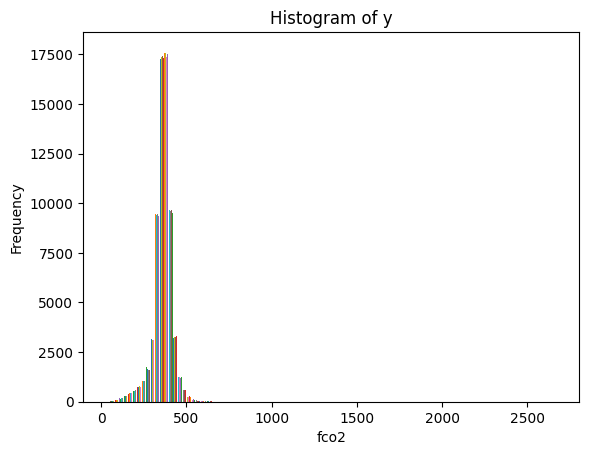

In [138]:

import matplotlib.pyplot as plt
feat = 0
# print some statistics of feature ignoring nans
print('Feature statistics:')
print('Mean:', np.nanmean(ds[:, feat, :]))
print('Std:', np.nanstd(ds[:, feat, :]))
print('Min:', np.nanmin(ds[:, feat, :]))
print('Max:', np.nanmax(ds[:, feat, :]))
print('Median:', np.nanmedian(ds[:, feat, :]))
print('25th percentile:', np.nanpercentile(ds[:, feat, :], 25))
print('75th percentile:', np.nanpercentile(ds[:, feat, :], 75))
# 95th percentile
print('95th percentile:', np.nanpercentile(ds[:, feat, :], 95))
# print('IQR:', np.nanpercentile(ds[:, feat, :], 75) - np.nanpercentile(ds[:, feat, :], 25))
# print('Skewness:', pd.Series(ds[:, feat, :].flatten()).skew())
# print('Kurtosis:', pd.Series(ds[:, feat, :].flatten()).kurtosis())
# print('Number of NaNs:', np.isnan(ds[:, feat, :]).sum())

# plot histogram of the first dimension of the dataset
plt.hist(ds[:, feat, :], bins=100)
plt.xlabel('fco2')
plt.ylabel('Frequency')
plt.title('Histogram of y')
plt.show()

In [139]:
fco2 = 0
# print greatest 10 values of fco2
fco2_arr = ds[:, fco2, :].flatten()
fco2_arr = fco2_arr[~np.isnan(fco2_arr)]
fco2_arr = np.sort(fco2_arr)
print('Greatest 10 values of fco2:')
print(fco2_arr[-200:])

Greatest 10 values of fco2:
[ 899.42569231  899.801375    899.93341667  901.71275     901.84116667
  901.991125    902.743       903.85785714  904.427       904.69471429
  906.22475     906.79875714  906.9185      913.01478571  913.69705263
  915.02088889  915.96766667  916.76457143  918.08283333  918.82633333
  918.90314286  919.261       921.328125    921.339       922.31685714
  922.65575     922.82942857  923.975       924.04866667  925.01875
  925.59        927.005       928.012       931.31025     931.34125
  934.33471429  934.64983333  934.85671429  934.92608333  935.10288889
  935.2395      935.82013333  937.3552      937.7475      938.42666667
  939.29666667  939.39271429  939.64469231  941.07983333  941.3934
  941.6358      943.80858333  944.86183333  945.85966667  947.07888889
  951.53975     957.50418182  959.001       959.672625    960.11816667
  960.32683333  960.50216667  960.84207692  962.964       965.19059091
  967.317       968.66778947  969.52428571  973.04466667  9

In [140]:
# print percentage of samples with fco2 > 500
threshold = 500
print(f'Percentage of samples with fco2 > {threshold}:')
print(np.sum(fco2_arr > threshold) / len(fco2_arr) * 100)
print(np.sum(fco2_arr > threshold))

Percentage of samples with fco2 > 500:
0.7782378451816628
33636


Text(0.5, 1.0, 'Latitude and Longitude of fco2 values greater than 500')

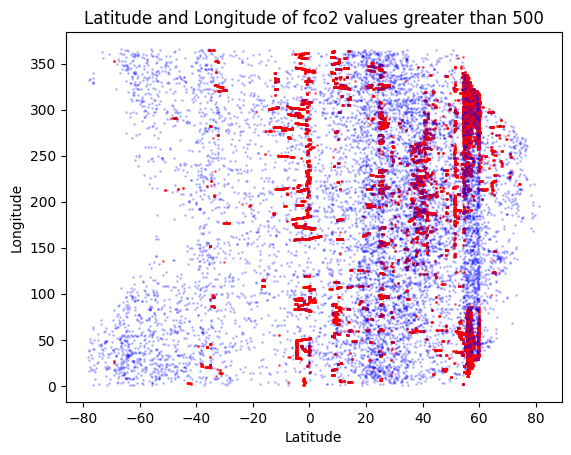

In [75]:
lat = 7
lon = 5


# plot lat and lon of the fco2 values greater than 500
fco2_arr = ds[:, fco2, :].flatten()
mask = np.isnan(fco2_arr)
fco2_arr = fco2_arr[~mask]
lat_arr = ds[:, lat, :].flatten()[~mask]
lon_arr = ds[:, lon, :].flatten()[~mask]
plt.scatter(lat_arr[fco2_arr > threshold], lon_arr[fco2_arr > threshold], c='red', s=1, alpha=0.5)
# plot also 100 random fco2 coordinates for comparison
rand_indices = np.random.choice(len(fco2_arr), 10000, replace=False)
plt.scatter(lat_arr[rand_indices], lon_arr[rand_indices], c='blue', s=1, alpha=0.2)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Latitude and Longitude of fco2 values greater than 500')

In [109]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib

def plot_world(data, feature='sst_cci', filter=None):
    if filter is not None:
        data[~filter] = np.nan
    # create a map of the world with coastlines and countries
    # data with shape (n_samples, 3) where the first column is the feature, second is latitude and third is longitude
    da = pd.DataFrame(data, columns=[feature, 'lat', 'lon'])
    da = da.groupby(['lat', 'lon']).mean()

    da = da.reset_index()
    da['lat'] = (da['lat'] * 4).round() / 4
    da['lon'] = (da['lon'] * 4).round() / 4
    da = da.set_index(['lat', 'lon'])
    da = da.groupby(['lat', 'lon']).mean()
    da = da.to_xarray()

    fig, ax = plt.subplots(
     figsize=(9, 5), 
     subplot_kw=dict( 
         projection=ccrs.EqualEarth()  # the map projection we want to use
                     ), 
     dpi=100)
    
    img = da.compute()[feature].plot.imshow(
    ax=ax,
    # aspect=2.5,  # our image has a 2 x 1 aspect, but leave space for colorbar 
    # size=4,  # sets the image height
    cmap='cmo.thermal',  # cmocean is a cmap library for oceanographic data - when imported cmaps are registered to matplotlib under cmo.<name>
    transform=ccrs.PlateCarree()
    )
    ax.coastlines(lw=1)  # axes with cartopy projection have a coastlines method
    ax.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='0.8', linewidth=0.3)
    return img
    

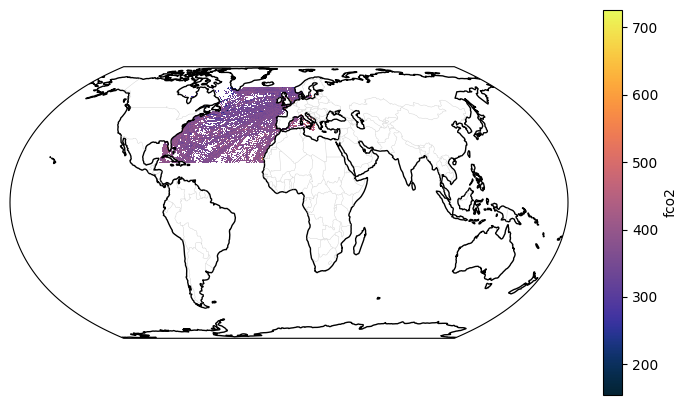

In [136]:
# data = np.concatenate([fco2_arr[:, np.newaxis], lat_arr[:, np.newaxis], lon_arr[:, np.newaxis]], axis=1)
data = np.zeros((ds.shape[0]*ds.shape[2], 3))
data[:, 0] = ds[:, 0, :].flatten()
data[:, 1] = ds[:, 7, :].flatten() 
data[:, 2] = (ds[:, 8, :].flatten() + 180) % 360 - 180#(lon + 180) % 360 - 180
# filter = data[:, 0] > 1000
lat_low = 19
# lon_low = -86
lon_low = -86
lat_high = 62
lon_high = 18
filter =  (data[:, 2] > lon_low) & (data[:, 2] < lon_high) & (data[:, 1] > lat_low) & (data[:, 1] < lat_high) 
plot_world(data, feature='fco2', filter=filter)

In [61]:
import xarray as xr
data = np.zeros((ds.shape[0]*ds.shape[2], 3))
data[:, 0] = ds[:, 1, :].flatten()
data[:, 1] = ds[:, 7, :].flatten()
data[:, 2] = ds[:, 8, :].flatten()
da_sst = pd.DataFrame(data, columns=['sst_cci', 'lat', 'lon'])
da_sst = da_sst.groupby(['lat', 'lon']).mean()
da_sst.head()

,,sst_cci
lat,lon,
-78.591248,196.578995,271.604980
-78.585503,196.739670,271.616669
-78.578720,196.262848,271.600006
-78.568413,196.075500,271.600006
-78.564911,196.931900,271.619995


In [62]:
# round coordiates to nearest 0.25 degrees
da_sst = da_sst.reset_index()
da_sst['lat'] = (da_sst['lat'] * 4).round() / 4
da_sst['lon'] = (da_sst['lon'] * 4).round() / 4
da_sst = da_sst.set_index(['lat', 'lon'])
da_sst = da_sst.groupby(['lat', 'lon']).mean()
da_sst = da_sst.to_xarray()
# da_sst = da_sst.rename({'lat': 'latitude', 'lon': 'longitude'})

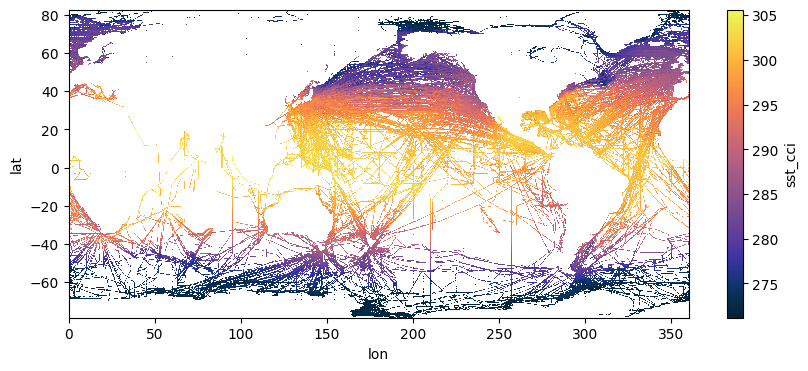

In [ ]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib
img = da_sst.compute().sst_cci.plot.imshow(
    aspect=2.5,  # our image has a 2 x 1 aspect, but leave space for colorbar 
    size=4,  # sets the image height
    cmap='cmo.thermal'  # cmocean is a cmap library for oceanographic data - when imported cmaps are registered to matplotlib under cmo.<name>
)